In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy # nltk can also be a good choice

# Import

In [2]:
df = pd.read_csv("data.csv")
df.columns = ["text", "s"]
# Sentiment to binary
df['s'] = df.s.map(lambda x: 1 if x == 'positive' else 0)

# Preprocessing

###  Lemmatize with spacy 
    - Keep only pos Noun, Adj, Verb

In [3]:
nlp_spacy = spacy.load("en_core_web_sm")

# Example
tokens = nlp_spacy("Hi brother! How are you today? You feel good?")
print(str(tokens[0]))

# Lematize
def lemmatize_text(text, nlp_spacy, allowed_pos_tags=["NOUN", "ADJ", "VERB"]): ## ADV
    tokens = nlp_spacy(text)
    return [(str(tok), tok.lemma_) for tok in tokens if tok.pos_ in allowed_pos_tags]

# Save
df["lems_filtered"] = df["text"].map(lambda text: lemmatize_text(text, nlp_spacy))
df.to_pickle("lems_filtered_noun_adj_verb12345.pk")
#df = pd.read_pickle("lems_filtered_noun_adj_verb.pk")

In [5]:
df["lems"] = df["lems_filtered"].map(lambda l: " ".join([el[1] for el in l]))

### Preprocessing: parameters

### CountVectorizer (test)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stop_words
## CountVectorizer avec tous et regarder la distrib des fréquences
# - if domain specific : some high frequencies values then a whole in the support of the distribution then more common values 
min_df=0.1
max_df=0.8
ngram_range=[1,2]
cv = CountVectorizer(
    binary=True,
    min_df=min_df,
    max_df=max_df, 
    stop_words=stop_words,
    ngram_range=ngram_range
)

cv_mat = cv.fit_transform(df["lems"])

print(cv_mat.shape)

dfcv = pd.DataFrame(cv_mat.todense(), columns=cv.get_feature_names(), index=df.index)

dfcv.sum(axis=0).sort_values(ascending=False)

(50000, 69)


movie          32126
film           29282
good           23627
time           19756
watch          18012
               ...  
fan             5258
script          5223
believe         5141
interesting     5129
mean            5023
Length: 69, dtype: int64

### Preprocessing: tfidf

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf = TfidfVectorizer(
    smooth_idf=True,
    sublinear_tf=True,
    use_idf=True,
    # max_features
    min_df=min_df,
    max_df=max_df, 
    stop_words=stopwords,
    ngram_range=ngram_range)

tfidf_mat = tfidf.fit_transform(df["lems"])

print(tfidf_mat.shape)

dftfidf = pd.DataFrame(tfidf_mat.todense(), columns=tfidf.get_feature_names(), index=df.index)

(50000, 104)


### TruncatedSVD (for viz)

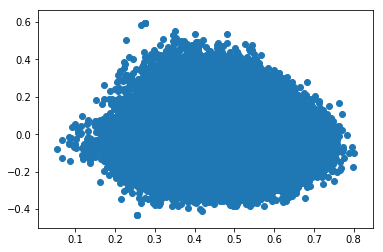

In [14]:
from sklearn.decomposition import TruncatedSVD, PCA

n_components = 5
dims = ["dim_{}".format(x) for x in range(1, n_components+1)]
svd = TruncatedSVD(n_components=n_components, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
res_svd =svd.fit_transform(tfidf_mat)
res_svd = pd.DataFrame(res_svd, index=df.index)

plt.scatter(res_svd[0], res_svd[1])
plt.show()

### Split data

In [15]:
from sklearn.model_selection import train_test_split

X = dftfidf.copy()
Y = df["s"]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

### Process: MultinomialNaïveBayes

### Fit / pred in sample

In [16]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
mnb.fit(X_train, Y_train)
pred = mnb.predict(X_train)
res = pd.DataFrame.from_dict({"pred":pred, "true":Y_train})
(res["pred"] == res["true"]).sum() / res.shape[0]

0.7408358208955224

### Out of sample

In [17]:
pred = mnb.predict(X_test)
res = pd.DataFrame.from_dict({"pred":pred, "true":Y_test})
print("Accuracy:", round((res["pred"] == res["true"]).sum() / res.shape[0], 2))

Accuracy: 0.74


### Metrics

In [18]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(Y_test, 
                                pred, 
                                beta=1.0, 
                                labels=None, 
                                pos_label=None, 
                                average=None, 
                                warn_for=('precision', 'recall', 'f-score'), 
                                sample_weight=None)


# precision
# recall
# fbeta_score
# support

(array([0.74689209, 0.73982971]),
 array([0.73196881, 0.75446213]),
 array([0.73935516, 0.74707428]),
 array([8208, 8292]))

### Pipeline + GridSearch

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None))])
    
    
param_grid = {
   # 'tfidf__max_df': (0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
    'tfidf__max_df': (0.05, 0.1, 0.2,  0.5,  0.9),
#    'tfidf__min_df': [0.001, 0.002, 0.005, 0.0075, 0.01],
    'tfidf__min_df': [0.001, 0.005, 0.01],
    'tfidf__smooth_idf': (False, True),
    'tfidf__sublinear_tf': (False, True),
    'tfidf__use_idf': (False, True),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': [(1, 1)],  # unigrams or bigrams
    'tfidf__use_idf': (False, True),
#    'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
    'clf__alpha': (0.1, 0.5, 1)
    # 'clf__max_iter': (10, 50, 80),
}

n = len(df)
grid = GridSearchCV(pipeline, n_jobs=5, param_grid=param_grid, verbose=10)
X = df["lems"].head(n)
Y = df["s"].head(n)
grid.fit(X, Y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV] clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV] clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV] clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False 
[CV] clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV] clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True 
[CV]  clf__alpha=0.1, tfidf__max_df=0.05, tfidf__min_df=0.001, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__s

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   29.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   58.1s
[Parallel(n_jobs=5)]: Done 958 tasks      | elapsed: 118.1min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 136.4min finished


# Apply the best model

In [45]:
n = len(df)
X = df["lems"].head(n)
Y = df["s"].head(n)

bestModel = Pipeline([
    ('tfidf', grid.best_estimator_.steps[0][1]),
    ('clf', grid.best_estimator_.steps[1][1]) 
])

bestModel.score(X,Y)

0.86392